In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline
from matplotlib import font_manager, rc

font_location = "C:\Windows\Fonts\malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


In [3]:
import xml.etree.ElementTree as ET
import pandas as pd

def load_xml_to_df(file):
    tree = ET.parse(file)
    root = tree.getroot()

    rows = []
    for event in root.find("glucose_level").findall("event"):
        ts = event.attrib["ts"]
        value = event.attrib["value"]
        rows.append([ts, float(value)])

    return pd.DataFrame(rows, columns=["timestamp", "glucose"])


files = ["570-ws-training.xml", "563-ws-training.xml", "588-ws-training.xml"]
patients = [load_xml_to_df(f) for f in files]


for i, df in enumerate(patients):
    print(f"환자 {i+1} 데이터 크기:", df.shape)
    print(df.head(), "\n")


환자 1 데이터 크기: (10982, 2)
             timestamp  glucose
0  07-12-2021 16:29:00    101.0
1  07-12-2021 16:34:00    100.0
2  07-12-2021 16:39:00    100.0
3  07-12-2021 16:44:00     99.0
4  07-12-2021 16:49:00     98.0 

환자 2 데이터 크기: (12124, 2)
             timestamp  glucose
0  13-09-2021 12:33:00    219.0
1  13-09-2021 12:38:00    229.0
2  13-09-2021 12:43:00    224.0
3  13-09-2021 12:48:00    221.0
4  13-09-2021 12:53:00    215.0 

환자 3 데이터 크기: (12640, 2)
             timestamp  glucose
0  30-08-2021 11:53:00    116.0
1  30-08-2021 11:58:00    117.0
2  30-08-2021 12:03:00    119.0
3  30-08-2021 12:08:00    116.0
4  30-08-2021 12:13:00    111.0 



In [4]:
for i, df in enumerate(patients):
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%d-%m-%Y %H:%M:%S")
    df.set_index("timestamp", inplace=True)
    
    patients[i] = df.resample("5T").mean().interpolate()


In [5]:
def create_features(df, horizon=24):  # horizon=24는 120분 후(5분 단위 × 24)
    X, y = [], []
    glucose = df["glucose"].values
    for i in range(len(glucose) - horizon - 12):
        recent = glucose[i:i+12]  # 최근 1시간(12*5분)
        target = glucose[i+horizon+12]  # 120분 뒤 값
        X.append(recent)
        y.append(target)
    return np.array(X), np.array(y)

X_list, y_list = [], []
for df in patients:
    X, y = create_features(df)
    X_list.append(X)
    y_list.append(y)

X_all = np.vstack(X_list)
y_all = np.hstack(y_list)


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)


In [7]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

model = LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

model.fit(X_train, y_train)
preds = model.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)

print("MAE:", mae)
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3033
[LightGBM] [Info] Number of data points in the train set: 30165, number of used features: 12
[LightGBM] [Info] Start training from score 165.823593
MAE: 32.56073143161153
RMSE: 42.62675835316315


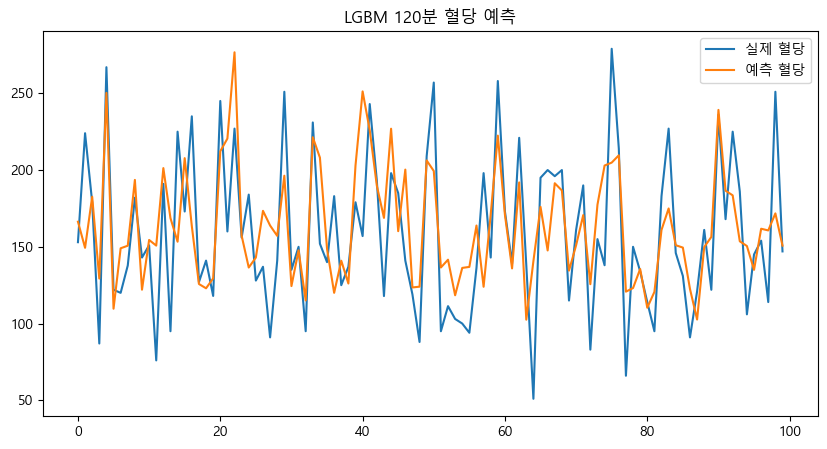

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test[:100], label="실제 혈당")
plt.plot(preds[:100], label="예측 혈당")
plt.legend()
plt.title("LGBM 120분 혈당 예측")
plt.show()


In [9]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test, preds)
rmse = mean_squared_error(y_test, preds, squared=False)
print("MAE:", mae)
print("RMSE:", rmse)


MAE: 32.56073143161153
RMSE: 42.62675835316315


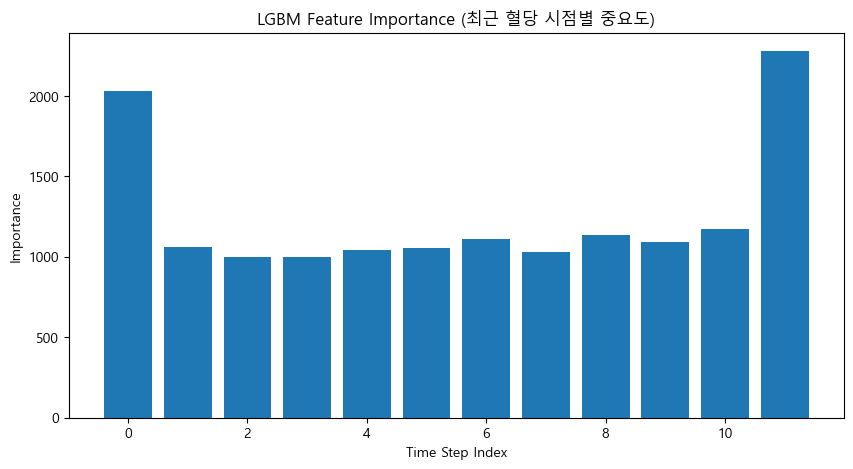

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.bar(range(X_train.shape[1]), model.feature_importances_)
plt.title("LGBM Feature Importance (최근 혈당 시점별 중요도)")
plt.xlabel("Time Step Index")
plt.ylabel("Importance")
plt.show()


In [12]:
import joblib


joblib.dump(model, "lgbm_glucose_model.pkl")




['lgbm_glucose_model.pkl']